In [1]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [2]:
# Step 1: Load the dataset
df = pd.read_csv("Part_Of_Speech.csv")
df

,Word,Is Noun,Is Verb,Is Adjective,Is Adverb,Is Conjunction,Is Preposition,Is Interjection,Is Pronoun
0,people,True,False,False,False,False,False,False,False
1,history,True,False,False,False,False,False,False,False
2,way,True,False,False,False,False,False,False,False
3,art,True,False,False,False,False,False,False,False
4,world,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2612,yonder,False,False,False,False,False,False,False,True
2613,your,False,False,False,False,False,False,False,True
2614,yours,False,False,False,False,False,False,False,True
2615,yourself,False,False,False,False,False,False,False,True


In [3]:
# Enhanced Feature Engineering
# Use TF-IDF for word vectorization instead of frequency
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Word']).toarray()

# Add TF-IDF vectorized words to the dataframe
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)

In [4]:
# Step 2: Feature engineering
df['Word_Length'] = df['Word'].apply(len)
df['Vowel_Count'] = df['Word'].apply(lambda x: sum(1 for char in x if char.lower() in 'aeiou'))
df['Consonant_Count'] = df['Word'].apply(lambda x: sum(1 for char in x if char.isalpha() and char.lower() not in 'aeiou'))

# Feature: Syllable Count
def count_syllables(word):
    vowels = "aeiouy"
    count = 0
    previous_char = ""

    for char in word.lower():
        if char in vowels and previous_char not in vowels:
            count += 1
        previous_char = char

    # Adjust count for certain cases
    if word.endswith('e'):
        count -= 1
    if count == 0:
        count = 1  # At least one syllable for a word

    return count

df['Syllable_Count'] = df['Word'].apply(count_syllables)

# Feature: Word Frequency
word_frequency = df['Word'].value_counts().to_dict()
df['Word_Frequency'] = df['Word'].map(word_frequency)

# Feature: Prefix and Suffix Lengths (example with one common prefix and suffix)
common_prefix = 'un'
common_suffix = 'ing'
df[f'Prefix_{common_prefix}_Length'] = df['Word'].apply(lambda x: len(common_prefix) if x.startswith(common_prefix) else 0)
df[f'Suffix_{common_suffix}_Length'] = df['Word'].apply(lambda x: len(common_suffix) if x.endswith(common_suffix) else 0)

# Feature: Presence of Punctuation
df['Has_Punctuation'] = df['Word'].apply(lambda x: any(char.isalnum() for char in x))

# Display the updated dataset with the new features
df

,Word,Is Noun,Is Verb,Is Adjective,Is Adverb,Is Conjunction,Is Preposition,Is Interjection,Is Pronoun,ability,...,yup,zone,Word_Length,Vowel_Count,Consonant_Count,Syllable_Count,Word_Frequency,Prefix_un_Length,Suffix_ing_Length,Has_Punctuation
0,people,True,False,False,False,False,False,False,False,0.0,...,0.0,0.0,6,3,3,1,1,0,0,True
1,history,True,False,False,False,False,False,False,False,0.0,...,0.0,0.0,7,2,5,3,1,0,0,True
2,way,True,False,False,False,False,False,False,False,0.0,...,0.0,0.0,3,1,2,1,1,0,0,True
3,art,True,False,False,False,False,False,False,False,0.0,...,0.0,0.0,3,1,2,1,1,0,0,True
4,world,True,False,False,False,False,False,False,False,0.0,...,0.0,0.0,5,1,4,1,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612,yonder,False,False,False,False,False,False,False,True,0.0,...,0.0,0.0,6,2,4,1,1,0,0,True
2613,your,False,False,False,False,False,False,False,True,0.0,...,0.0,0.0,4,2,2,1,1,0,0,True
2614,yours,False,False,False,False,False,False,False,True,0.0,...,0.0,0.0,5,2,3,1,1,0,0,True
2615,yourself,False,False,False,False,False,False,False,True,0.0,...,0.0,0.0,8,3,5,1,1,0,0,True


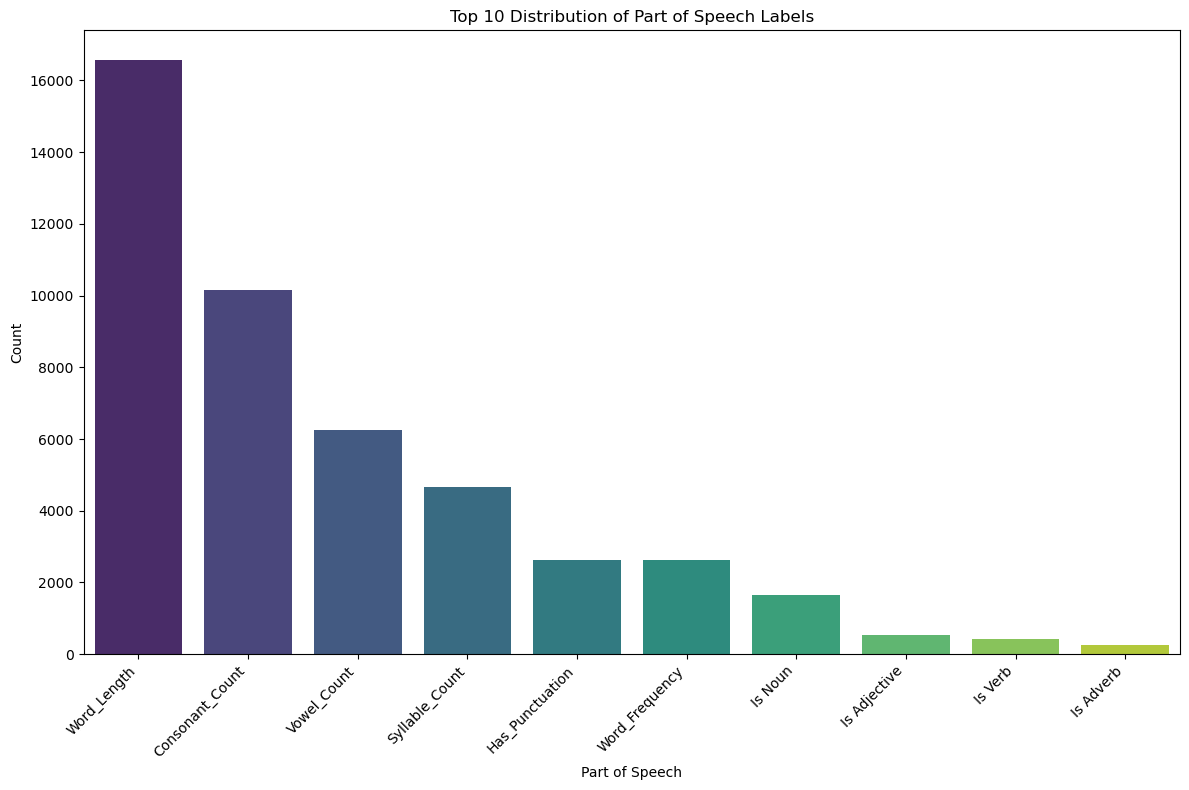

In [5]:
# Step 3: Visualization of the dataset
# Calculate the sum of each label to find the top 10
label_sums = df.iloc[:, 1:].sum().sort_values(ascending=False)
top_labels = label_sums.head(10).index

# Filter the dataframe to include only the top 10 labels
df_top_labels = df[top_labels]

# Visualize the distribution of the top 10 'Is Noun', 'Is Verb', etc.
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=df_top_labels.columns, y=df_top_labels.sum().values, palette='viridis')

plt.title('Top 10 Distribution of Part of Speech Labels')
plt.xlabel('Part of Speech')
plt.ylabel('Count')

# Rotate the labels on the x-axis for better legibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

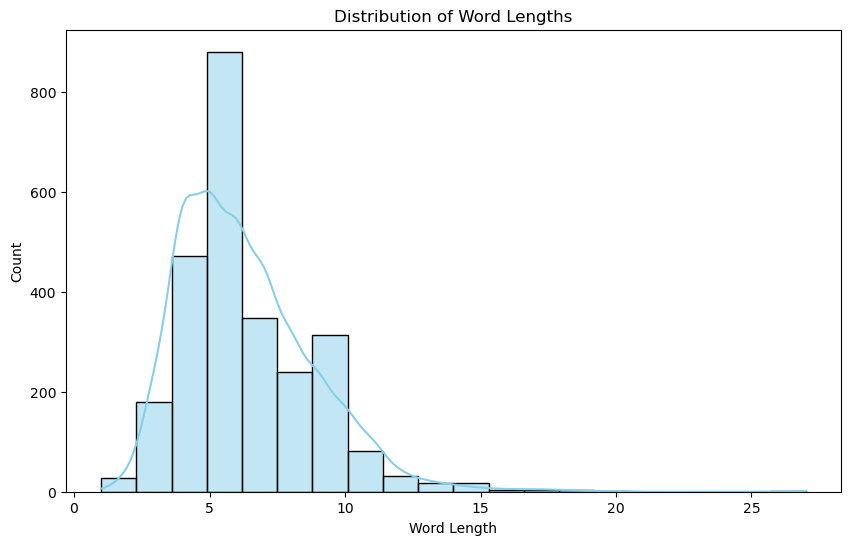

In [6]:
# Visualize the distribution of word lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['Word_Length'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.show()

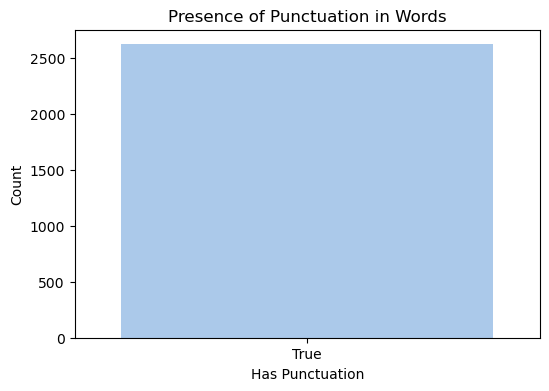

In [7]:
# Visualize the presence of punctuation
plt.figure(figsize=(6, 4))
sns.countplot(x='Has_Punctuation', data=df, palette='pastel')
plt.title('Presence of Punctuation in Words')
plt.xlabel('Has Punctuation')
plt.ylabel('Count')
plt.show()


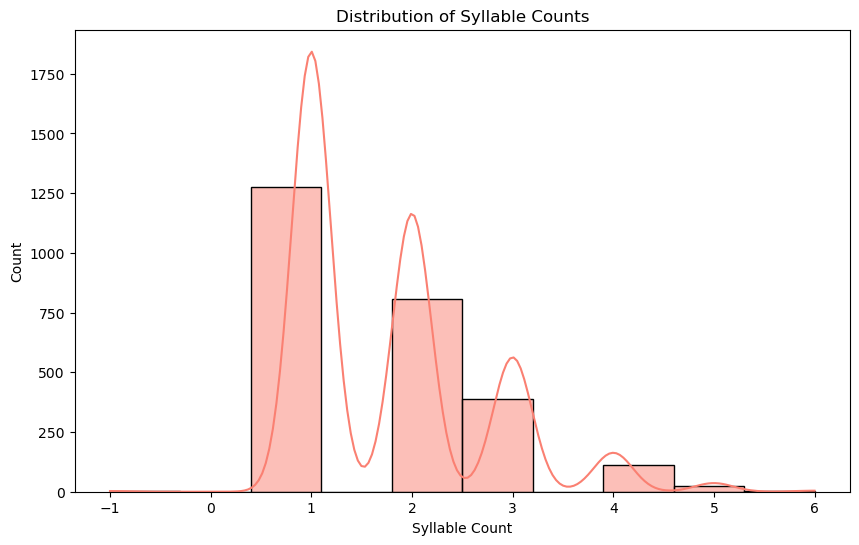

In [8]:
# Visualize the distribution of syllable counts
plt.figure(figsize=(10, 6))
sns.histplot(df['Syllable_Count'], bins=10, kde=True, color='salmon')
plt.title('Distribution of Syllable Counts')
plt.xlabel('Syllable Count')
plt.ylabel('Count')
plt.show()

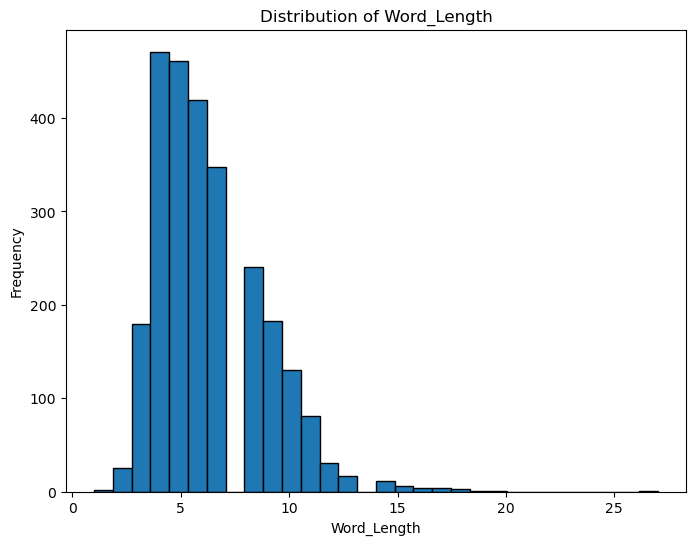

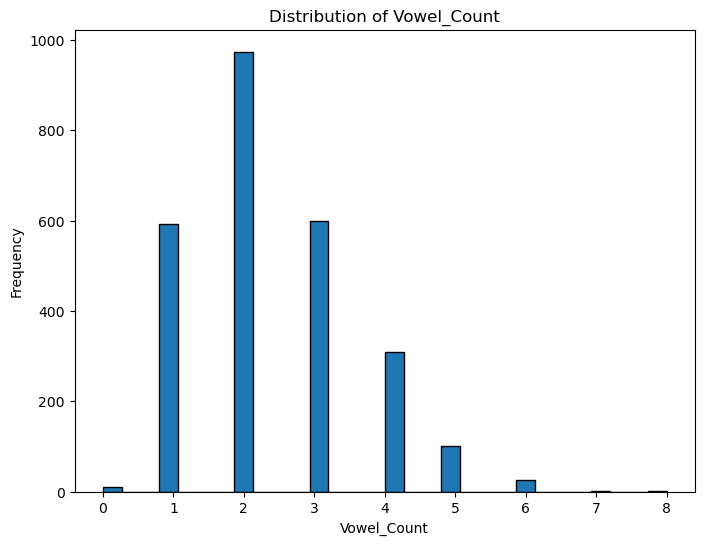

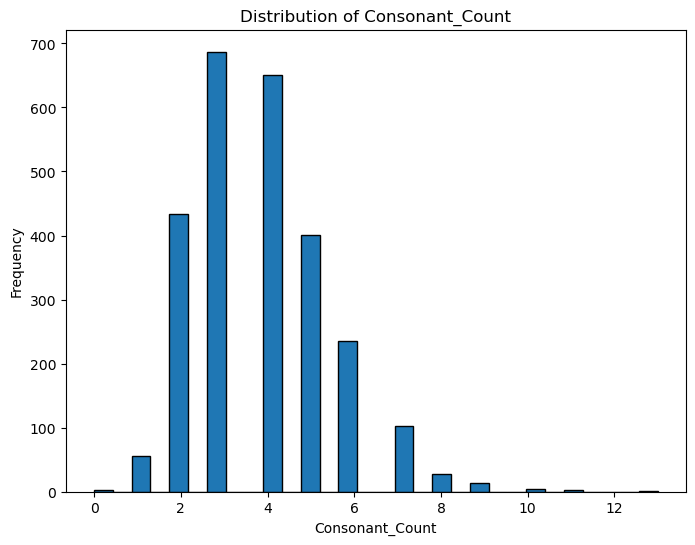

Potential outliers for Word_Length:

                             Word  Word_Length
182                responsibility           14
218                administration           14
224                recommendation           14
293                transportation           14
1507               representative           14
1819  lie (not to tell the truth)           27
2038               administrative           14
2371               a minute later           14
2373           after a short time           18
2377             as a consequence           16
2383              because of this           15
2388            equally important           17
2391             for this purpose           16
2392              for this reason           15
2405             in spite of this           16
2408             in the meanwhile           16
2409              in the meantime           15
2410           in the same manner           18
2411              in the same way           15
2412            just as

In [9]:
# Step 4: Analyze and handle outliers

# Select three features for analysis
selected_features = ['Word_Length', 'Vowel_Count', 'Consonant_Count']

# Visualize the distribution of selected features
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    plt.hist(df[feature], bins=30, edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Identify and handle potential outliers
for feature in selected_features:
    # Use z-score for outlier detection
    z_scores = (df[feature] - df[feature].mean()) / df[feature].std()
    outliers = df[(z_scores > 3) | (z_scores < -3)]

    # Print information about outliers
    if not outliers.empty:
        print(f'Potential outliers for {feature}:\n')
        print(outliers[['Word', feature]],'\n')

        # Replace outliers with the mean value of the feature
        mean_value = df[feature].mean()
        df.loc[outliers.index, feature] = mean_value
        print(f'Replaced outliers with the mean value ({mean_value}) for {feature}\n')
    else:
        print(f'No potential outliers found for {feature}\n')

In [10]:
# Split the dataset into features and target variables
X = df.drop(columns=['Word', 'Is Noun', 'Is Verb', 'Is Adjective', 'Is Adverb', 'Is Conjunction', 'Is Preposition', 'Is Interjection', 'Is Pronoun'])
y = df[['Is Noun', 'Is Verb', 'Is Adjective', 'Is Adverb', 'Is Conjunction', 'Is Preposition', 'Is Interjection', 'Is Pronoun']]

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **LOGISTIC REGRESSION**

---



In [12]:
# Step 6: Train a logistic regression model with hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Define a simpler parameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__solver': ['liblinear'],  # Faster solver for smaller datasets
    'estimator__max_iter': [100]  # Fewer iterations to speed up convergence
}

# Initialize RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    MultiOutputClassifier(LogisticRegression(class_weight='balanced')),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_iter=100,  # Only iterate 100 times
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [13]:
# Step 7: Test the model and report metrics
y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Logistic Regression Metrics\n")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report for Logistic Regression\n", classification_report(y_test, y_pred))

Logistic Regression Metrics

Accuracy: 0.48091603053435117
Precision: 0.4073716102223907
Recall: 0.5263975155279503
F1 Score: 0.4366705036226193

Classification Report for Logistic Regression
               precision    recall  f1-score   support

           0       0.66      0.98      0.79       332
           1       0.00      0.00      0.00        83
           2       0.09      0.01      0.02       104
           3       0.00      0.00      0.00        54
           4       0.64      0.26      0.37        27
           5       0.50      0.16      0.24        19
           6       0.00      0.00      0.00         7
           7       0.33      0.06      0.10        18

   micro avg       0.63      0.53      0.57       644
   macro avg       0.28      0.18      0.19       644
weighted avg       0.41      0.53      0.44       644
 samples avg       0.64      0.57      0.59       644



C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **PRINCIPAL COMPONENT ANALYSIS**

---



In [14]:
# Step 8: Use PCA to reduce dimensionality with hyperparameter tuning
pca = PCA()

# Create a pipeline with PCA and logistic regression
pipe = Pipeline(steps=[('pca', PCA()), ('estimator', MultiOutputClassifier(LogisticRegression()))])

# Define the parameter grid for PCA and logistic regression hyperparameters
param_grid_pca = {
    'pca__n_components': [2, 5, 10, 20, 50],
    'estimator__estimator__C': [0.1, 1, 10],
    'estimator__estimator__solver': ['lbfgs']  # or other solvers as needed
}

# Perform grid search to find the best parameters including the number of PCA components
random_search_pca = RandomizedSearchCV(pipe, param_grid_pca, cv=5, scoring='accuracy', verbose = 1)
random_search_pca.fit(X_train, y_train)  # Use original X_train here, not transformed

# Get the best parameters and estimator from the random search
best_params_pca = random_search_pca.best_params_
best_estimator_pca = random_search_pca.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [15]:
# Step 9: Test the new model and report metrics
y_pred_pca = best_estimator_pca.predict(X_test)  # Use original X_test here, not transformed

# Calculate the evaluation metrics using the predictions
accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca, average='weighted')
recall_pca = recall_score(y_test, y_pred_pca, average='weighted')
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')

print("Logistic Regression Metrics with PCA\n")
print(f"Accuracy: {accuracy_pca}")
print(f"Precision: {precision_pca}")
print(f"Recall: {recall_pca}")
print(f"F1 Score: {f1_pca}")
print("\nClassification Report for Logistic Regression with PCA:\n", classification_report(y_test, y_pred_pca))

Logistic Regression Metrics with PCA

Accuracy: 0.48854961832061067
Precision: 0.3931062954065481
Recall: 0.5201863354037267
F1 Score: 0.4240494077941104

Classification Report for Logistic Regression with PCA:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79       332
           1       0.00      0.00      0.00        83
           2       0.00      0.00      0.00       104
           3       0.00      0.00      0.00        54
           4       0.80      0.15      0.25        27
           5       0.67      0.11      0.18        19
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        18

   micro avg       0.66      0.52      0.58       644
   macro avg       0.27      0.16      0.15       644
weighted avg       0.39      0.52      0.42       644
 samples avg       0.64      0.56      0.59       644



C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


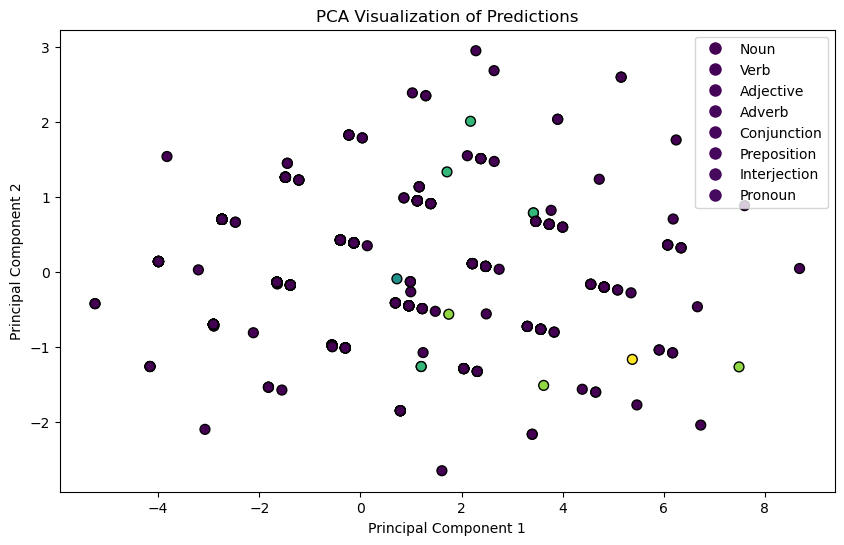

In [16]:
# Step 11: Visualization
X_test_pca = best_estimator_pca.named_steps['pca'].transform(X_test)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_pca.argmax(axis=1), cmap='viridis', edgecolors='k', s=50)
plt.title('PCA Visualization of Predictions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend for all classes
legend_labels = ['Noun', 'Verb', 'Adjective', 'Adverb', 'Conjunction', 'Preposition', 'Interjection', 'Pronoun']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in plt.get_cmap('viridis').colors]
plt.legend(handles=legend_handles, labels=legend_labels)

plt.show()


# **WORD EMBEDDINGS - WORD2VEC**

---



In [17]:
# Step 12: Word Embeddings Hyperparameter Tuning

# Tokenize and preprocess text
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['Tokens'] = df['Word'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Step 13: Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['Tokens'], vector_size=100, window=10, min_count=1, workers=4)

In [19]:
# Step 14: Feature Extraction
def get_word_vector(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return [0] * 100

# Feature Extraction with the best Word2Vec model
df['Word_Embeddings'] = df['Tokens'].apply(lambda tokens: [get_word_vector(word) for word in tokens])

# Feature: Average word embeddings for each example
df['Average_Word_Embedding'] = df['Word_Embeddings'].apply(lambda embeddings: sum(embeddings) / len(embeddings) if embeddings else [0] * 100)

# Feature: Word Frequency
word_frequency = df['Word'].value_counts().to_dict()
df['Word_Frequency'] = df['Word'].map(word_frequency)

# Feature: Presence of Punctuation
df['Has_Punctuation'] = df['Word'].apply(lambda x: any(char.isalnum() for char in x))


In [20]:
# Step 15: Feature Scaling
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(df['Average_Word_Embedding'].tolist())
df[['embedding_'+str(i) for i in range(100)]] = pd.DataFrame(scaled_embeddings, columns=['embedding_'+str(i) for i in range(100)])

C:\Users\vedan\AppData\Local\Temp\ipykernel_32312\780226515.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['embedding_'+str(i) for i in range(100)]] = pd.DataFrame(scaled_embeddings, columns=['embedding_'+str(i) for i in range(100)])
C:\Users\vedan\AppData\Local\Temp\ipykernel_32312\780226515.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['embedding_'+str(i) for i in range(100)]] = pd.DataFrame(scaled_embeddings, columns=['embedding_'+str(i) for i in range(100)])
C:\Users\vedan\AppData\Local\Temp\ipykernel_3231

In [21]:
# Step 16: Split the data
X_word2vec = df[['Word_Frequency', 'Has_Punctuation'] + ['embedding_'+str(i) for i in range(100)]]
y_word2vec = df[['Is Noun', 'Is Verb', 'Is Adjective', 'Is Adverb', 'Is Conjunction', 'Is Preposition', 'Is Interjection', 'Is Pronoun']]

# Split the data into training and test sets
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)

In [22]:
# Step 17: Hyperparameter Tuning for Logistic Regression on Word Embeddings
logistic_regression_word2vec = LogisticRegression()

param_grid_word2vec = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                       'solver': ['lbfgs', 'liblinear', 'newton-cg'],
                       'max_iter': [1000, 5000, 10000]}

grid_search_word2vec = GridSearchCV(logistic_regression_word2vec, param_grid_word2vec, cv=5, scoring='accuracy')
grid_search_word2vec.fit(X_train_word2vec, y_train_word2vec.idxmax(axis=1))

best_params_word2vec = grid_search_word2vec.best_params_
best_estimator_word2vec = grid_search_word2vec.best_estimator_


In [23]:
# Step 18: Predictions and Evaluation of the new model
y_pred_word2vec = best_estimator_word2vec.predict(X_test_word2vec)

accuracy_word2vec = accuracy_score(y_test_word2vec.idxmax(axis=1), y_pred_word2vec)
precision_word2vec = precision_score(y_test_word2vec.idxmax(axis=1), y_pred_word2vec, average='weighted')
recall_word2vec = recall_score(y_test_word2vec.idxmax(axis=1), y_pred_word2vec, average='weighted')
f1_word2vec = f1_score(y_test_word2vec.idxmax(axis=1), y_pred_word2vec, average='weighted')
report_word2vec = classification_report(y_test_word2vec.idxmax(axis=1), y_pred_word2vec)

print("\nLogistic Regression Metrics with Word Embeddings\n")
print(f"Accuracy: {accuracy_word2vec}")
print(f"Precision: {precision_word2vec}")
print(f"Recall: {recall_word2vec}")
print(f"F1 Score: {f1_word2vec}")
print("\nClassification Report for Logistic Regression with Word Embeddings:\n", report_word2vec)


Logistic Regression Metrics with Word Embeddings

Accuracy: 0.6335877862595419
Precision: 0.401433482897267
Recall: 0.6335877862595419
F1 Score: 0.4914746379396447

Classification Report for Logistic Regression with Word Embeddings:
                  precision    recall  f1-score   support

   Is Adjective       0.00      0.00      0.00        57
      Is Adverb       0.00      0.00      0.00        31
 Is Conjunction       0.00      0.00      0.00        18
Is Interjection       0.00      0.00      0.00         7
        Is Noun       0.63      1.00      0.78       332
 Is Preposition       0.00      0.00      0.00        13
     Is Pronoun       0.00      0.00      0.00        13
        Is Verb       0.00      0.00      0.00        53

       accuracy                           0.63       524
      macro avg       0.08      0.12      0.10       524
   weighted avg       0.40      0.63      0.49       524



C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedan\Anaconda3\lib\site-packages\sklearn\metrics\_classifi

# **Comparing the model metrics of Logistic Regression, PCA, Logistic Regression with Word Embeddings**




Confusion Matrix Heatmap for Logistic Regression



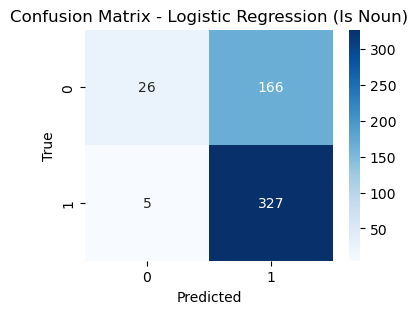

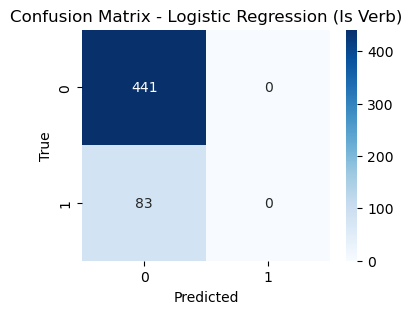

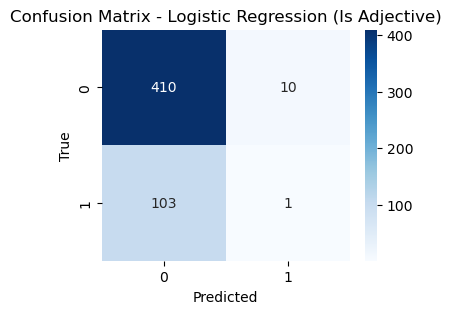

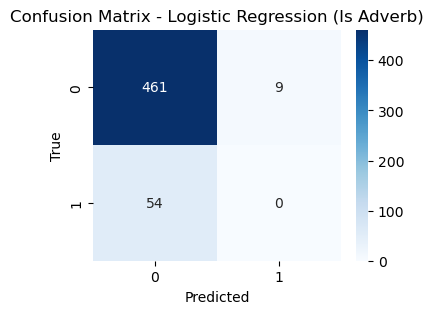

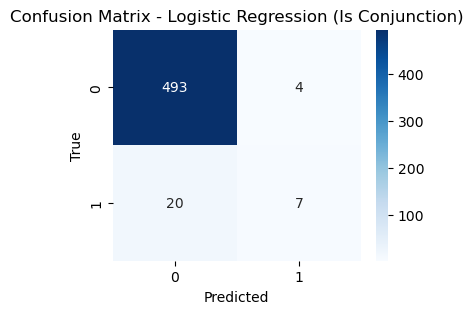

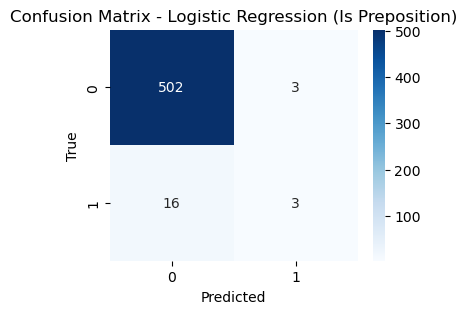

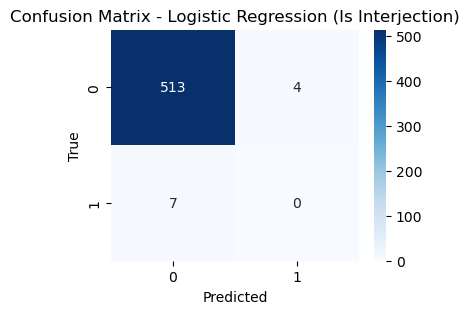

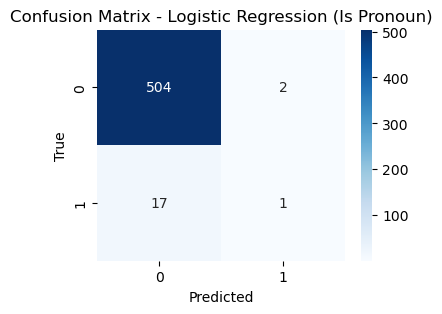


Confusion Matrix Heatmap for Logistic Regression with PCA



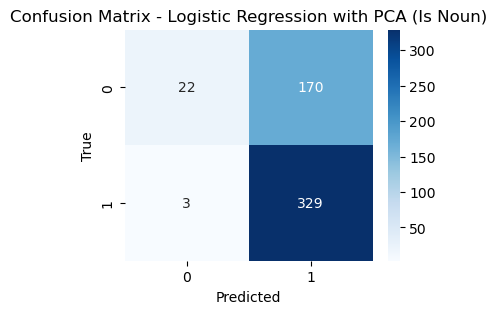

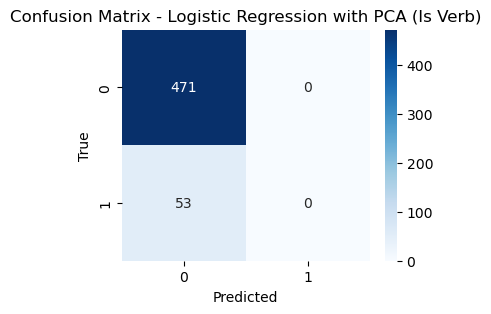

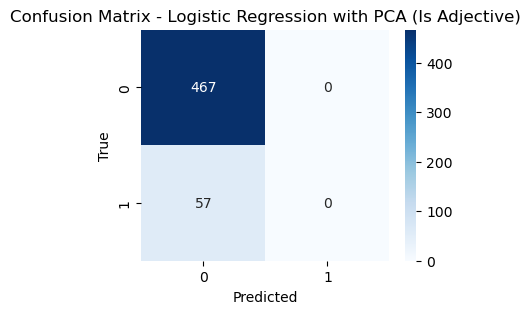

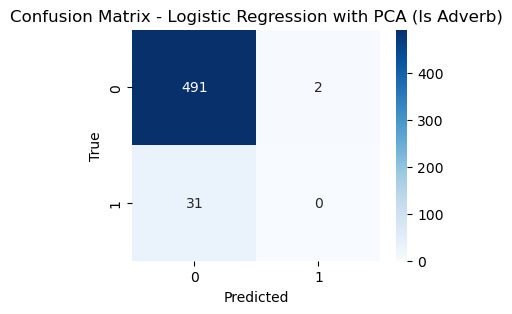

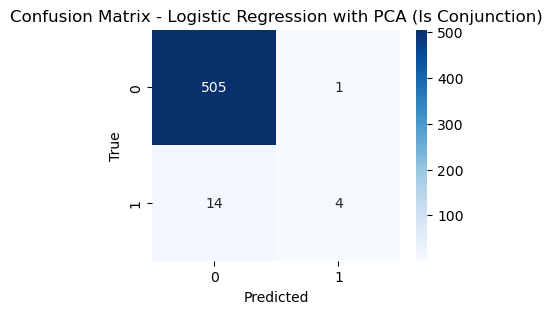

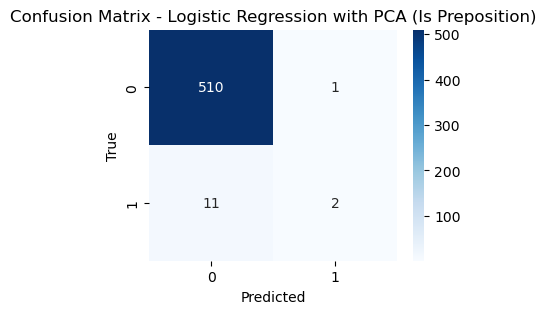

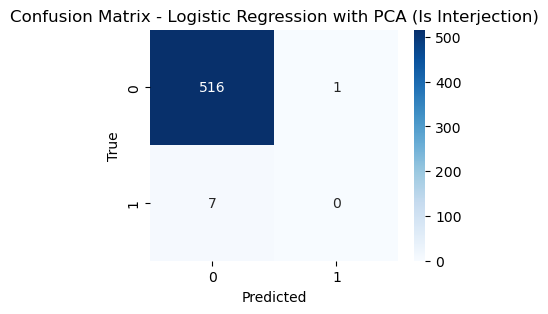

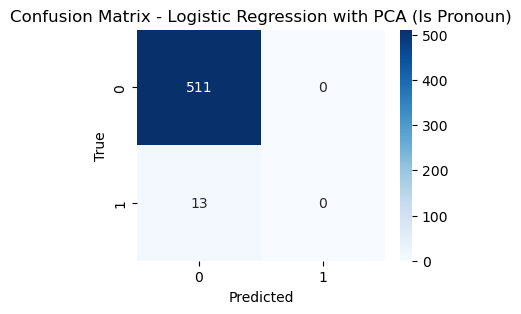


Confusion Matrix Heatmap for Logistic Regression with Word Embeddings



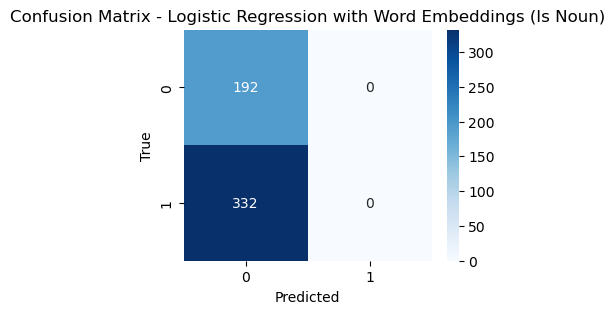

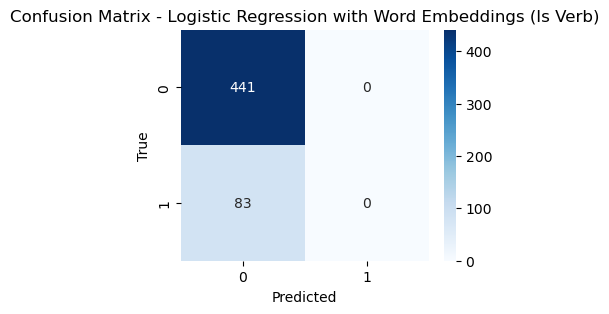

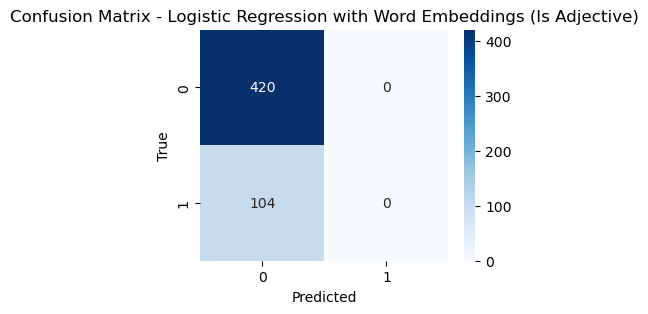

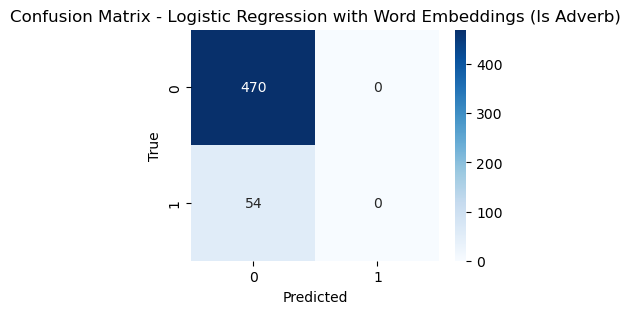

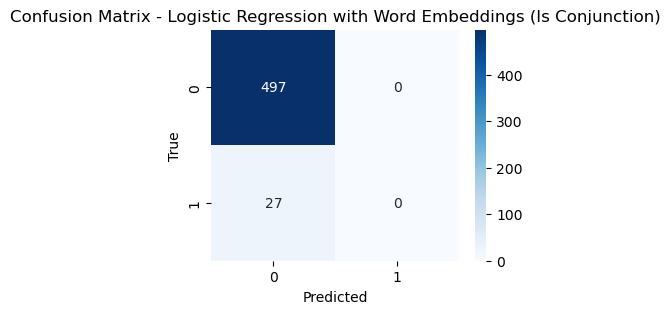

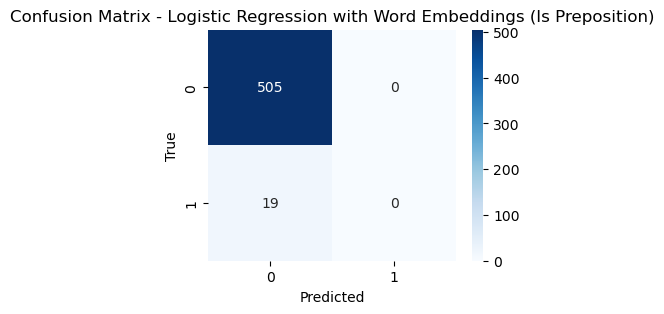

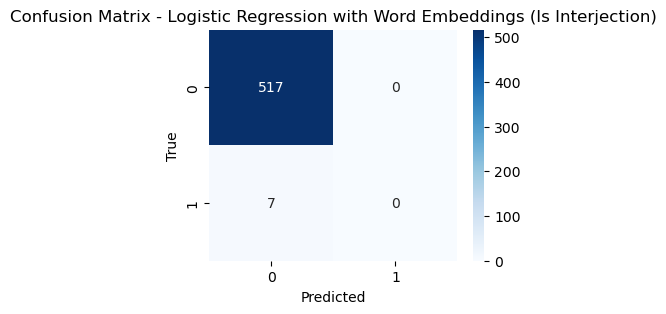

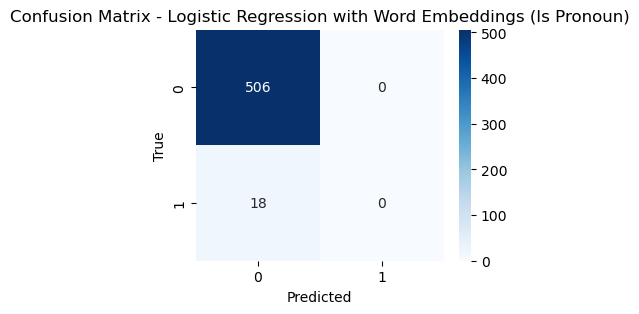


Logistic Regression Metrics
Accuracy: 0.48091603053435117
Precision: 0.4073716102223907
Recall: 0.5263975155279503
F1 Score: 0.4366705036226193

PCA Model Metrics
Accuracy: 0.48854961832061067
Precision: 0.3931062954065481
Recall: 0.5201863354037267
F1 Score: 0.4240494077941104

Logistic Regression with Word Embeddings Metrics
Accuracy: 0.6335877862595419
Precision: 0.401433482897267
Recall: 0.6335877862595419
F1 Score: 0.4914746379396447


In [24]:
# Step 19: Visualization of Model Comparisons

# Function to plot confusion matrix heatmap
def plot_confusion_matrix_heatmap(y_true, y_pred, labels, model_name):
    for i, label in enumerate(labels):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        matrix = confusion_matrix(y_true_label, y_pred_label)

        plt.figure(figsize=(4, 3))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {model_name} ({label})')
        plt.show()

# Confusion Matrix Heatmap for Logistic Regression
print("\nConfusion Matrix Heatmap for Logistic Regression\n")
plot_confusion_matrix_heatmap(label_binarize(y_test.values, classes=[0, 1, 2, 3, 4, 5, 6, 7]), label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7]), labels=df.columns[1:9], model_name='Logistic Regression')

# Confusion Matrix Heatmap for PCA
print("\nConfusion Matrix Heatmap for Logistic Regression with PCA\n")
plot_confusion_matrix_heatmap(label_binarize(np.argmax(y_test.values, axis=1), classes=[0, 1, 2, 3, 4, 5, 6, 7]), label_binarize(y_pred_pca, classes=[0, 1, 2, 3, 4, 5, 6, 7]), labels=df.columns[1:9], model_name='Logistic Regression with PCA')

# Confusion Matrix Heatmap for Logistic Regression with Word Embeddings
print("\nConfusion Matrix Heatmap for Logistic Regression with Word Embeddings\n")
plot_confusion_matrix_heatmap(label_binarize(y_test_word2vec, classes=[0, 1, 2, 3, 4, 5, 6, 7]), label_binarize(y_pred_word2vec, classes=[0, 1, 2, 3, 4, 5, 6, 7]), labels=df.columns[1:9], model_name='Logistic Regression with Word Embeddings')

# Compare Logistic Regression models
print("\nLogistic Regression Metrics")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("\nPCA Model Metrics")
print(f"Accuracy: {accuracy_pca}")
print(f"Precision: {precision_pca}")
print(f"Recall: {recall_pca}")
print(f"F1 Score: {f1_pca}")

print("\nLogistic Regression with Word Embeddings Metrics")
print(f"Accuracy: {accuracy_word2vec}")
print(f"Precision: {precision_word2vec}")
print(f"Recall: {recall_word2vec}")
print(f"F1 Score: {f1_word2vec}")

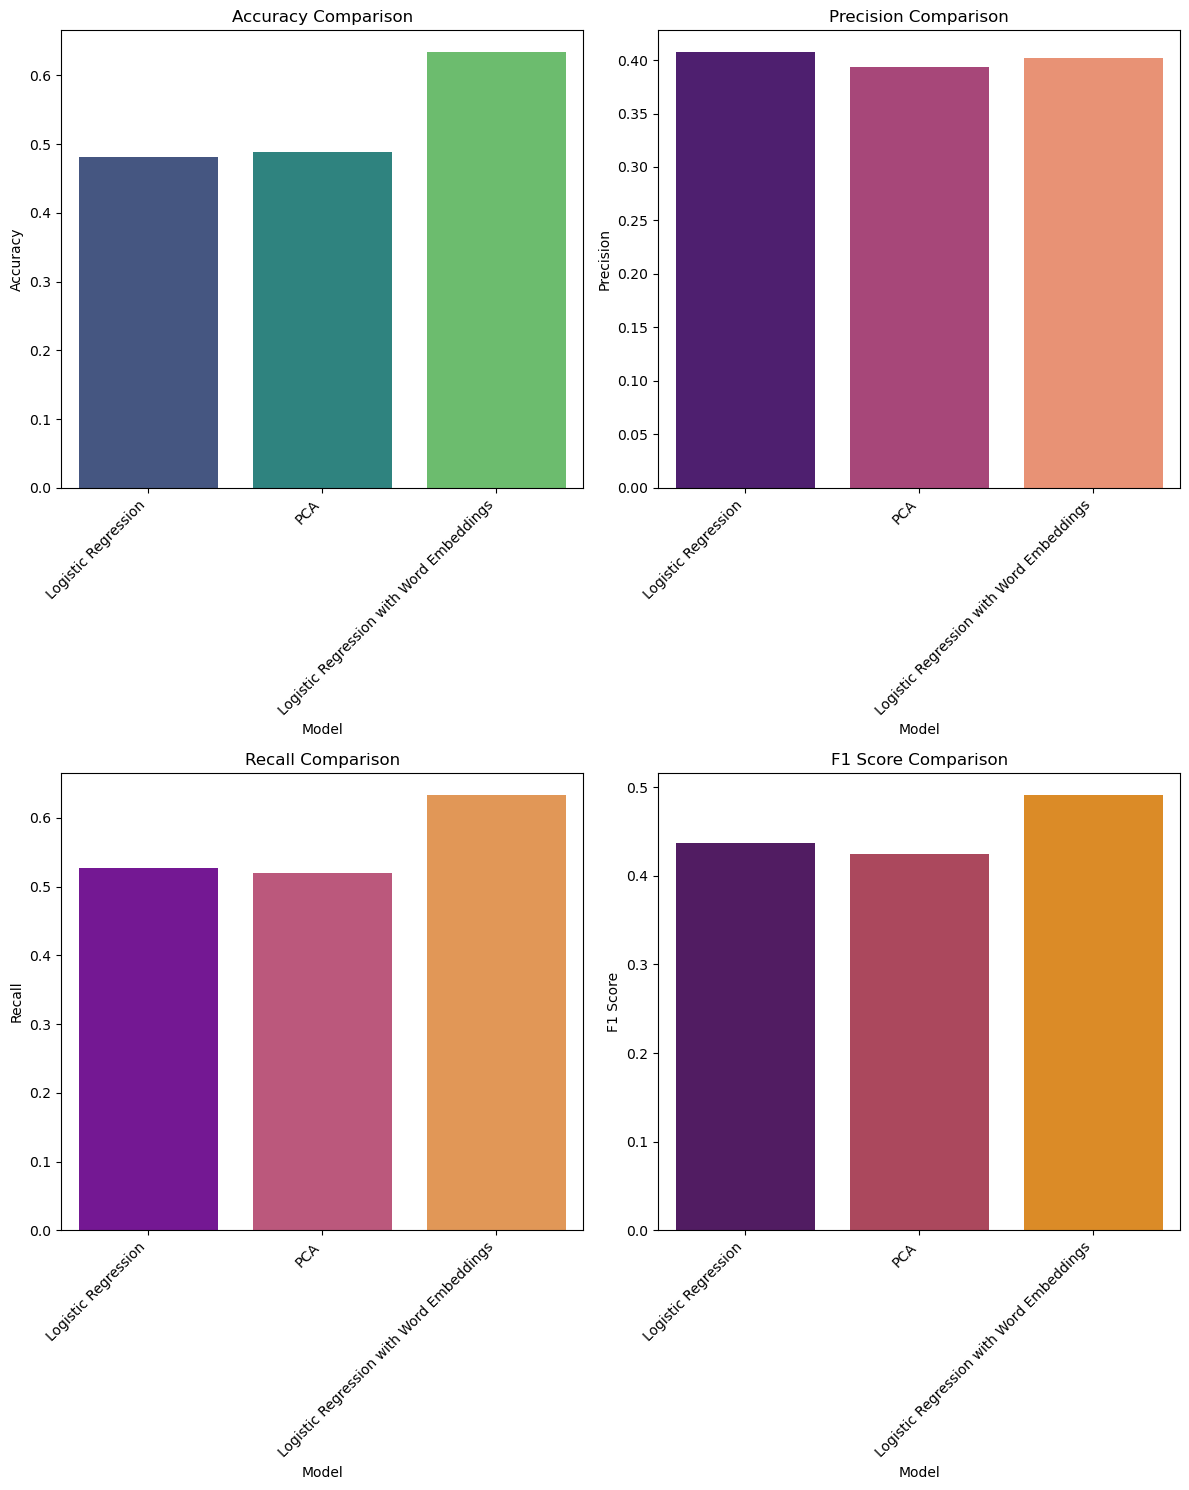

In [25]:
# Create a DataFrame for model metrics
metrics_data = {
    'Model': ['Logistic Regression', 'PCA', 'Logistic Regression with Word Embeddings'],
    'Accuracy': [accuracy, accuracy_pca, accuracy_word2vec],
    'Precision': [precision, precision_pca, precision_word2vec],
    'Recall': [recall, recall_pca, recall_word2vec],
    'F1 Score': [f1, f1_pca, f1_word2vec]
}

metrics_df = pd.DataFrame(metrics_data)

# Visualization
plt.figure(figsize=(12, 15))

# Accuracy Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45, ha='right')

# Precision Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=metrics_df, palette='magma')
plt.title('Precision Comparison')
plt.xticks(rotation=45, ha='right')

# Recall Comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=metrics_df, palette='plasma')
plt.title('Recall Comparison')
plt.xticks(rotation=45, ha='right')

# F1 Score Comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='inferno')
plt.title('F1 Score Comparison')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()